In [1]:
using Random, Printf, Plots, Statistics
using Oceananigans, Oceananigans.OutputWriters, Oceananigans.Diagnostics, Oceananigans.Utils
using Oceananigans.Fields, Oceananigans.Operators

┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv /Users/kidsampson/.julia/packages/CUDAdrv/aBgcd/src/CUDAdrv.jl:69


## Model parameters

Here we use an isotropic, cubic grid with `Nz` grid points and grid spacing
`Δz = 1` meter. We specify fluxes of heat, momentum, and salinity via

   1. A temperature flux `Qᵀ` at the top of the domain, which is related to heat flux
       by `Qᵀ = Qʰ / (ρ₀ * cᴾ)`, where `Qʰ` is the heat flux, `ρ₀` is a reference density,
       and `cᴾ` is the heat capacity of seawater. With a reference density
       `ρ₀ = 1026 kg m⁻³`and heat capacity `cᴾ = 3991`, our chosen temperature flux of
       `Qᵀ = 5 × 10⁻⁵ K m⁻¹ s⁻¹` corresponds to a heat flux of `Qʰ = 204.7 W m⁻²`, a
       relatively powerful cooling rate.

   2. A velocity flux `Qᵘ` at the top of the domain, which is related
       to the `x` momentum flux `τˣ` via `τˣ = ρ₀ * Qᵘ`, where `ρ₀` is a reference density.
       Our chosen value of `Qᵘ = -2 × 10⁻⁵ m² s⁻²` roughly corresponds to atmospheric winds
       of `uᵃ = 2.9 m s⁻¹` in the positive `x`-direction, using the parameterization
       `τ = 0.0025 * |uᵃ| * uᵃ`.

   3. An evaporation rate `evaporation = 10⁻⁷ m s⁻¹`, or approximately 0.1 millimeter per
       hour.

Finally, we use an initial temperature gradient of `∂T/∂z = 0.005 K m⁻¹`,
which implies an iniital buoyancy frequency `N² = α * g * ∂T/∂z = 9.8 × 10⁻⁶ s⁻²`
with a thermal expansion coefficient `α = 2 × 10⁻⁴ K⁻¹` and gravitational acceleration
`g = 9.81 s⁻²`. Note that, by default, the `SeawaterBuoyancy` model uses a gravitational
acceleration `gᴱᵃʳᵗʰ = 9.80665 s⁻²`.

In [2]:
Nx, Ny, Nz = 16, 16, 16    # No. of grid points in x, y, and z, respectively.
Lx, Ly, Lz = 40, 40, 16    # Length of the domain in x, y, and z, respectively (m).
topology = (Periodic, Periodic, Bounded) # topology of the grid
nothing # hide

In [3]:
grid = RegularCartesianGrid(topology=topology, size=(Nx, Ny, Nz), length=(Lx, Ly, Lz))

RegularCartesianGrid{Float64, Periodic, Periodic, Bounded}
domain: x ∈ [0.0, 40.0], y ∈ [0.0, 40.0], z ∈ [-16.0, 0.0]
  resolution (Nx, Ny, Nz) = (16, 16, 16)
   halo size (Hx, Hy, Hz) = (1, 1, 1)
grid spacing (Δx, Δy, Δz) = (2.5, 2.5, 1.0)

In [4]:
const Ekman_deg = 17*pi/180
const g  = 9.80665 # gravitation on earth
const u★ = 0.008 # [m s⁻¹], friction velocity
const f  = 1e-4     # Coriolis parameter
const omega = -f/8
nothing

In [5]:
# fluxes *kinematic* because they are applied to the velocity field. 
x_momentum_flux(x, y, t) = u★^2 * cos(omega * t)
y_momentum_flux(x, y, t) = u★^2 * sin(omega * t) 

τˣ = BoundaryFunction{:z, Face, Cell}(x_momentum_flux)
τʸ = BoundaryFunction{:z, Cell, Face}(y_momentum_flux)

u_bcs = UVelocityBoundaryConditions(grid,
                                    top=BoundaryCondition(Flux, τˣ),
                                 bottom=BoundaryCondition(Value, 0))
v_bcs = VVelocityBoundaryConditions(grid,
                                    top=BoundaryCondition(Flux, τʸ),
                                 bottom=BoundaryCondition(Value, 0))
nothing

In [6]:
         Qᵀ = 0 #5e-5  # Temperature flux at surface
         Qᵘ = 1e-5     # Velocity flux at surface
       ∂T∂z = 1e0     # Initial vertical temperature gradient
   ∂T∂z_bot = 1e-2  # initial temp gradient in the bottom layer
evaporation = 0 # 1e-7     # Mass-specific evaporation rate [m s⁻¹]
          α = 2e-4     # Thermal expansion coefficient
          β = 8e-4     # Haline contraction coefficient
nothing # hide

## Boundary conditions

Here we define `Flux` boundary conditions at the surface for `u`, `T`, and `S`,
and a `Gradient` boundary condition on `T` that maintains a constant stratification
at the bottom. Our flux boundary condition for salinity uses a function that calculates
the salinity flux in terms of the evaporation rate.

In [7]:
bot_TL = 11
top_TL = 7
bot_temp = 20 + ∂T∂z * (top_TL-bot_TL) + ∂T∂z_bot * (bot_TL - Lz) + ∂T∂z_bot * ( 0.0 - top_TL)
T_bcs = TracerBoundaryConditions(grid, top = BoundaryCondition(Flux, Qᵀ),
                                    bottom = BoundaryCondition(Gradient, ∂T∂z_bot))
nothing

In [8]:
model = IncompressibleModel(
         architecture = CPU(),
                 grid = grid,
             coriolis = FPlane(f=f),
             buoyancy = SeawaterBuoyancy(equation_of_state=LinearEquationOfState(α=α, β=β)),
              closure = AnisotropicMinimumDissipation(),
  boundary_conditions = (u=u_bcs, v=v_bcs, T=T_bcs),
)
nothing # hide

### Notes:

* To use the Smagorinsky-Lilly turbulence closure (with a constant model coefficient) rather than
  `AnisotropicMinimumDissipation`, use `closure = ConstantSmagorinsky()` in the model constructor.

* To change the `architecture` to `GPU`, replace the `architecture` keyword argument with
  `architecture = GPU()``

## Initial conditions

Our initial condition for temperature consists of a linear stratification superposed with
random noise damped at the walls, while our initial condition for velocity consists
only of random noise.

In [9]:
## Temperature initial condition 1: a stable density tradient with random noise superposed.
T₀(x, y, z) = 20 + ∂T∂z * z 

## Temperature initial condition 2: OML -> pycnocline -> stably stratified bottom layer
function tempset_fxn(x, y, z)
    if abs(z) < top_TL
        20  + ∂T∂z_bot * z
    elseif abs(z) > bot_TL
        20 + ∂T∂z_bot * top_TL + ∂T∂z * (top_TL-bot_TL) + ∂T∂z_bot * z
    else 
        20 + ∂T∂z * (z+top_TL) 
    end
end

## Random noise damped at top and bottom
Ξ(z) = randn() * z / model.grid.Lz * (1 + z / model.grid.Lz) # noise
## Velocity initial condition: random noise scaled by the friction velocity.
#u₀(x, y, z) = u★ * 1e-6 * Ξ(z)

function horvel_set_fxn(x, y, z)
    if abs(z) < top_TL
        1e-6 * Ξ(z)
    else 
        1e-10 * Ξ(z)
    end
end

function w_set_fxn(x, y, z)
    if abs(z) < top_TL
        u★^2 * 1e-4 * Ξ(z)
    else 
        0
    end
end
nothing # hide

In [10]:
set!(model, u=horvel_set_fxn, v=horvel_set_fxn, T=tempset_fxn, S=31.5)

In [11]:
function diff3D(A::Array, dim::Integer)
    if dim == 1
        [A[i+1,j,k] - A[i,j,k] for i=1:size(A,1)-1, j=1:size(A,2), k=1:size(A,3)]
    elseif dim == 2
       [A[i,j+1,k] - A[i,j,k] for i=1:size(A,1), j=1:size(A,2)-1, k=1:size(A,3)]
    elseif dim == 3
       [A[i,j,k+1] - A[i,j,k] for i=1:size(A,1), j=1:size(A,2), k=1:size(A,3)-1]
    else
        throw(ArgumentError("dimension dim must be 1, 2, or 3 got $dim"))
    end
end

diff3D (generic function with 1 method)

In [12]:
function hor_mean(array, axis)
    n = size(array)[axis]
    k = zeros(n)
    for i in 1:n
        k[i]= mean(array[:,:,i])
    end
    return k
end    

hor_mean (generic function with 1 method)

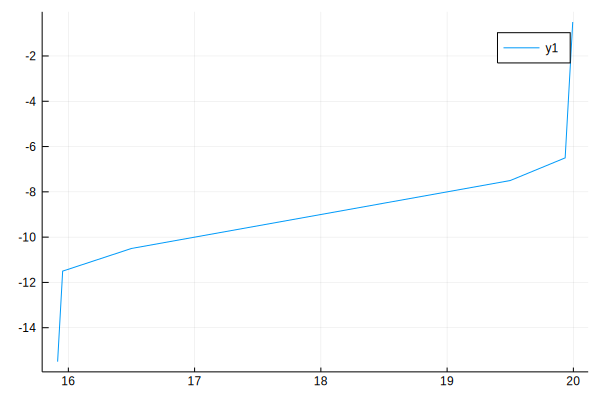

In [13]:
Temps = Array(interior(model.tracers.T))
plot(hor_mean(Temps,3),model.grid.zC)

## Set up output

We set up an output writer that saves all velocity fields, tracer fields, Temps the subgrid
turbulent diffusivity associated with `model.closure`. The `prefix` keyword argument
to `JLD2OutputWriter` indicates that output will be saved in
`ocean_wind_mixing_and_convection.jld2`.

In [14]:
## Create a NamedTuple containing all the fields to be outputted.
# fields_to_output = merge(model.velocities, model.tracers, (νₑ=model.diffusivities.νₑ,))

#####
##### Set up output
#####
fields =       Dict("u" => model.velocities.u,
                    "v" => model.velocities.v,
                    "w" => model.velocities.w,
                    "T" => model.tracers.T,
                    "S" => model.tracers.S,)

outputattrib = Dict("u" => ["longname" => "Velocity in the x-direction", "units" => "m/s"],
                    "v" => ["longname" => "Velocity in the y-direction", "units" => "m/s"],
                    "w" => ["longname" => "Velocity in the z-direction", "units" => "m/s"],
                    "T" => ["longname" => "Temperature", "units" => "K"],
                    "S" => ["longname" => "Salinity", "units" => "g/kg"])

globalattrib = Dict("f" => 1e-4, "alpha" => 2e-4, "beta" => 8e-4, "g" => 9.80665,)

nothing # hide

## Running the simulation

To run the simulation, we instantiate a `TimeStepWizard`

This ensures stable time-stepping with a Courant-Freidrichs-Lewy (CFL) number of 0.2.

In [15]:
const t_i = 2*pi/f

wizard = TimeStepWizard(cfl=0.2, Δt=1.0, max_change=1.1, max_Δt=5.0)
nothing # hide

function terse_message_sim(sim)
    update_Δt!(wizard, model)
    cfl = sim.Δt.Δt / Oceananigans.cell_advection_timescale(model)
    return @printf("i: %d, t: %.4f y, Δt: %.1f s, cfl: %.3f\n",
                    sim.model.clock.iteration, sim.model.clock.time/t_i, sim.Δt.Δt, cfl)
end
nothing 

In [16]:
tf = t_i
sim = Simulation(model; Δt=wizard, stop_time=tf, progress_frequency=10000, progress=terse_message_sim)
nothing

In [17]:
sim.output_writers[:field_writer] =
         NetCDFOutputWriter(model, fields; filename="../data/wind_shear_test.nc",
                            interval=t_i/100, output_attributes=outputattrib, 
                            global_attributes=globalattrib,)
nothing

In [18]:
update_Δt!(wizard, model)

In [19]:
run!(sim)

i: 10000, t: 0.1751 y, Δt: 1.2 s, cfl: 0.103
i: 20000, t: 0.3869 y, Δt: 1.5 s, cfl: 0.160
i: 30000, t: 0.6432 y, Δt: 1.8 s, cfl: 0.181
i: 40000, t: 0.9534 y, Δt: 2.1 s, cfl: 0.103
i: 50000, t: 1.3287 y, Δt: 2.6 s, cfl: 0.174


┌ Info: Simulation is stopping. Model time 23.189 hr has hit or exceeded simulation stop time 17.453 hr.
└ @ Oceananigans.Simulations /Users/kidsampson/.julia/packages/Oceananigans/Vea3t/src/Simulations.jl:118


In [20]:
sim

Simulation{IncompressibleModel{CPU, Float64}}
├── Model clock: time = 23.189 hr, iteration = 50000 
├── Next time step (TimeStepWizard{Float64}): 2.853 s 
├── Progress frequency: 10000
├── Stop criteria: Any[Oceananigans.Simulations.iteration_limit_exceeded, Oceananigans.Simulations.stop_time_exceeded, Oceananigans.Simulations.wall_time_limit_exceeded]
├── Run time: 3.411 min, wall time limit: Inf
├── Stop time: 17.453 hr, stop iteration: Inf
├── Diagnostics: OrderedCollections.OrderedDict with no entries
└── Output writers: OrderedCollections.OrderedDict with 1 entry:
│   └── field_writer => NetCDFOutputWriter